In [47]:
#import libraries
import torch
from torch import nn
torch.__version__

'2.0.0+cu118'

In [96]:
#set up device agnostic cpde
device = "cuda" if torch.cuda.is_available else "cpu"
device

'cuda'

Downloading custom datasets

In [49]:
import requests
import zipfile
from pathlib import Path

data_path = Path("data/")
image_path = data_path/ "pizza_Steak_Sushi"
if image_path.is_dir():
  print(f"{image_path} directory already exists")
else:
  print(f"{image_path} does not exists")
  image_path.mkdir(parents=True,exist_ok=True)

data/pizza_Steak_Sushi directory already exists


In [50]:
#Download sushi, Steak and pizza data
with open(data_path/ "pizza_steak_sushi.zip","wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloading pizza, steak and Sushi data")
  f.write(request.content)

#unzip fils
with zipfile.ZipFile(data_path/"pizza_steak_sushi.zip","r") as zip_ref:
  print("Unzipping------------------")
  zip_ref.extractall(image_path)


Unzipping------------------


Becoming one with the data(data preparation and exploration

In [51]:
import os 

def walk_through_dir(dir_path):
  for dirpath,dirnames,filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directory and {len(filenames)} images in {dirpath}")

walk_through_dir(data_path)


There are 1 directory and 1 images in data
There are 2 directory and 0 images in data/pizza_Steak_Sushi
There are 3 directory and 0 images in data/pizza_Steak_Sushi/train
There are 0 directory and 72 images in data/pizza_Steak_Sushi/train/sushi
There are 0 directory and 75 images in data/pizza_Steak_Sushi/train/steak
There are 0 directory and 78 images in data/pizza_Steak_Sushi/train/pizza
There are 3 directory and 0 images in data/pizza_Steak_Sushi/test
There are 0 directory and 31 images in data/pizza_Steak_Sushi/test/sushi
There are 0 directory and 19 images in data/pizza_Steak_Sushi/test/steak
There are 0 directory and 25 images in data/pizza_Steak_Sushi/test/pizza


In [52]:
#set up training and test path
train_dir = image_path / "train"
test_dir = image_path / "test"
train_dir,test_dir

(PosixPath('data/pizza_Steak_Sushi/train'),
 PosixPath('data/pizza_Steak_Sushi/test'))

Visualizing images
- Get all images path
- Pick random image path
- Get the image class names
- Open images with pillow
- Show image and print meta data

In [53]:
import random
from PIL import Image
#set seed
random.seed(42)
image_path

PosixPath('data/pizza_Steak_Sushi')

Random image path data/pizza_Steak_Sushi/train/sushi/3107839.jpg
Image class sushi
Image height 384
Image width 512


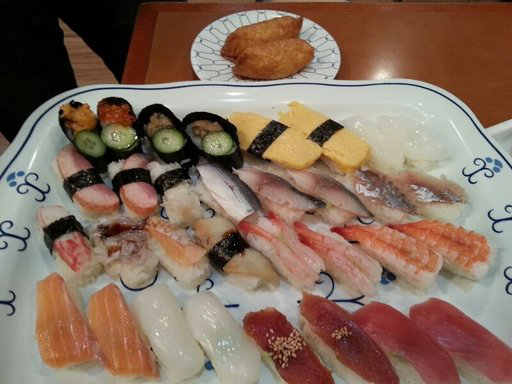

In [54]:
image_path_list = list(image_path.glob("*/*/*.jpg"))
#Select random images and plot
random_image_path = random.choice(image_path_list)

#Get image class name
image_class = random_image_path.parent.stem

#open image
img = Image.open(random_image_path)
#print metadata
print(f"Random image path {random_image_path}")
print(f"Image class {image_class}")
print(f"Image height {img.height}")
print(f"Image width {img.width}")
img

Visualizing with matplotlib

Text(0.5, 1.0, 'Image class:sushi | Image shape : (384, 512, 3)')

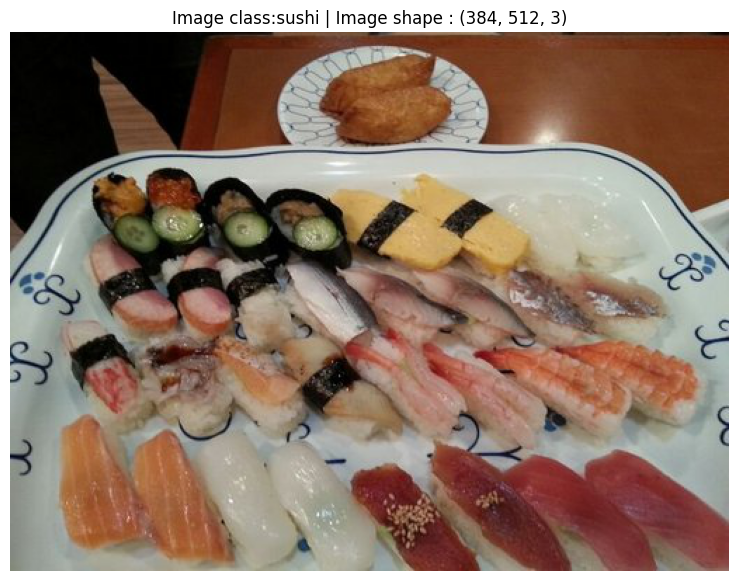

In [55]:
import numpy as np
import matplotlib.pyplot as plt

img_as_array = np.asarray(img)
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.axis(False)
plt.title(f"Image class:{image_class} | Image shape : {img_as_array.shape}")

Transforming data into tensors representation

In [56]:
from  torch.utils.data import DataLoader
from torchvision import datasets,transforms

In [57]:
#Write transform  for eaxh image
data_transform = transforms.Compose([
    #resize image
    transforms.Resize(size=(64,64)),
    #Flip image horizontally
    transforms.RandomHorizontalFlip(p=0.5),

    #Turn image to torch tensor
    transforms.ToTensor()]
)

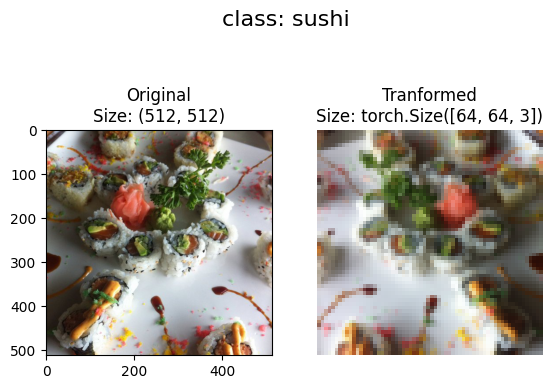

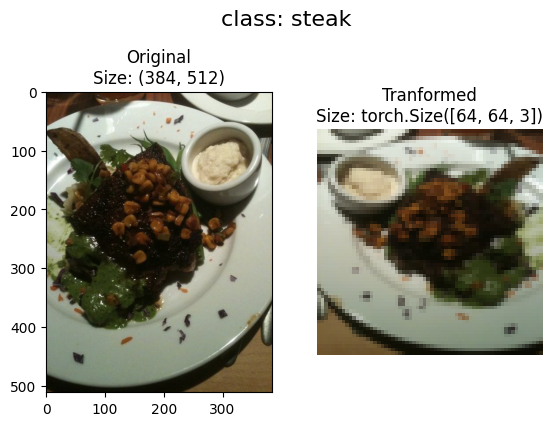

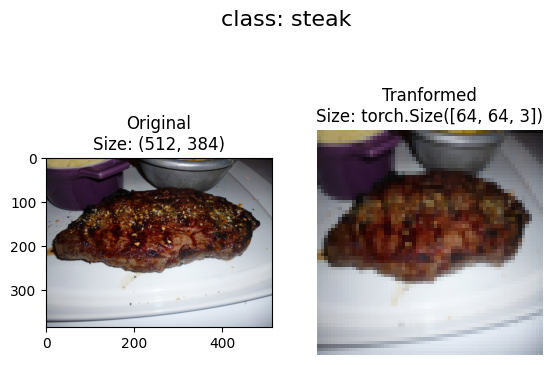

In [58]:
def plot_transformed_imgs(image_paths:list,transform,n=3,seed=None):
  if seed:
     random.seed(42)
  random_image_path = random.sample(image_paths,k=n)
  for img_path in random_image_path:
    with Image.open(img_path) as f:
      fig, ax = plt.subplots(nrows=1,ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")

      #Transfrom and plot target image
      transformed_img = transform(f).permute(1,2,0)
      ax[1].imshow(transformed_img)
      ax[1].set_title(f"Tranformed\nSize: {transformed_img.shape}") 
      ax[1].axis("off")
      fig.suptitle(f"class: {img_path.parent.stem}",fontsize=16)
  

plot_transformed_imgs(image_paths=image_path_list,transform=data_transform,n=3)

Loading image folder using ImageFolder

In [59]:
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_Steak_Sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_Steak_Sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [60]:
#Get class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [61]:
#Get class names as dic
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [62]:
#index on train data
img, label = train_data[0][0],train_data[0][1]

In [63]:
print(f"Image tensor:\n{img}")
print(f"Image shape:{img.shape}")
print(f"Image datatype:{img.dtype}")
print(f"Image label:{label}")
print(f"Label datatype:{type(label)}")

Image tensor:
tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0706, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0196, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.01

Image shape:torch.Size([64, 64, 3])


Text(0.5, 1.0, 'pizza')

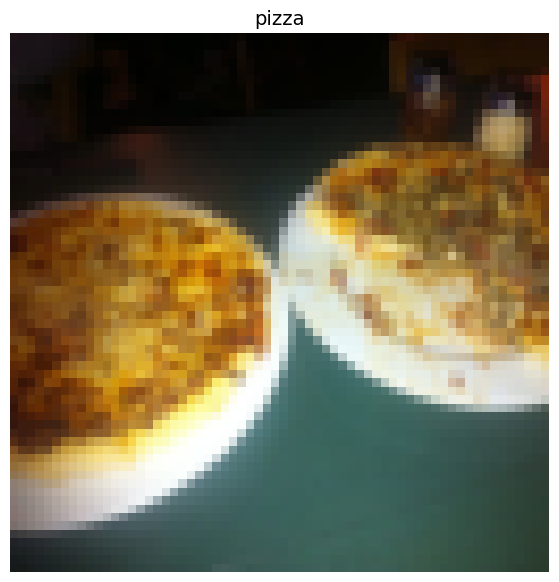

In [64]:
#Rearrange the order of dimension
img_permute = img.permute(1,2,0)
print(f"Image shape:{img_permute.shape}")
plt.figure(figsize=(10,7))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_names[label],fontsize=14)

Turning datasets into data loader
- Data loader turns datasets into iterables

In [65]:
from torch.utils.data import DataLoader
BATCH_SIZE = 1
train_dataloader = DataLoader(dataset=train_data,
                              batch_size = BATCH_SIZE ,
                              num_workers = os.cpu_count(),
                              shuffle = True

                              )
test_dataloader = DataLoader(dataset =test_data,
                             batch_size = BATCH_SIZE,
                             num_workers = 1,
                             shuffle = False
                             
    
)
len(train_dataloader), len(test_dataloader)

(225, 75)

In [66]:
#plot image from dataloader
img , label = next(iter(train_dataloader))
print(f"Image shape : {img.shape}")
print(f" Label shape : {label.shape}")

Image shape : torch.Size([1, 3, 64, 64])
 Label shape : torch.Size([1])


Replicating what ImageFolder do without using the ImageFolder library using Custom "Dataset"
- Loading image file
- Getting class names
- Getting class names as dictionary

Pros
- Can create a Datasets out of almost nothing
- Not limigted to pytorch pre built Datastes functions

Cons
- More codes will be written
- Can be prone to error

In [67]:
import os
import pathlib
import torch
import PIL
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [68]:
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### Creating helper function to get class names
- Scan through directory to ensure it is standard format
- Turn class names into didct and a list and return them


In [69]:
#Creating helper function to get class names
target_directory = train_dir 
print(f"Target dir: {target_directory}")

#Get class names from directory
class_names_found = sorted([entry.name  for entry in list(os.scandir(target_directory))])
print(f"Class names found : {class_names_found}")

Target dir: data/pizza_Steak_Sushi/train
Class names found : ['pizza', 'steak', 'sushi']


In [70]:
def find_classe(dir:str) -> Tuple[List[str], Dict[str,int]]:
  #find class names in target_dir
  classes = sorted([entry.name  for entry in list(os.scandir(dir))])
  #raise error if class name can not be found
  if not classes:
    raise FileNotFoundError(f"Cound not find any classes in {dir}....Please check file structure")

  #Create in dict of label and idex
  class_to_idx = {class_name:i for i,class_name in enumerate(classes)}
  return classes,class_to_idx
  

class_names, class_to_idx = find_classe(target_directory)

In [71]:
class_names,class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [72]:
class_names

['pizza', 'steak', 'sushi']

Create Custom  Datasets to replicate ImageFolder


In [73]:
#Write a custom datasets
from torch.utils.data import Dataset
class ImageFolderCustom(Dataset):
  #initilise custom datasets
  def __init__(self,targ_dir:str,transform=None):
    #Create class attributse
    self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))

    #set up transforms
    self.transform = transform

    #Creating classes and idx
    self.classes,self.class_to_idx = find_classe(targ_dir)

    #Create a function to load image 
  def load_image(self,index:int) -> Image.Image:
    #Opnes image via path and return it
    image_path = self.paths[index]
    return Image.open(image_path)
  def __len__(self) -> int:
    return len(self.paths)


  #overwrite get+item method to return a particular sample

  def __getitem__(self,index:int) -> Tuple[torch.Tensor,int]:
    #Return one sample of data and its label
    img = self.load_image(index)
    class_name = self.paths[index].parent.name #return parent folder of image
    class_idx = self.class_to_idx[class_name]

    #tranform if necessary
    if self.transform:
      return self.transform(img),class_idx
    else:
      return img,class_idx 



In [74]:
#Create a transform
train_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
    
])
test_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [75]:
train_data = ImageFolderCustom(targ_dir=train_dir,
                               transform=train_transform)
test_data = ImageFolderCustom(targ_dir=test_dir,
                              transform=test_transforms)

In [76]:
len(train_data),len(test_data)

(225, 75)

In [77]:
class_names = train_data.classes

In [78]:
train_data.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [79]:
class_names

['pizza', 'steak', 'sushi']

In [80]:
#Create function to display custom images
def display_random_images(dataset:torch.utils.data.Dataset,
                          classes:List[str] = None,
                          n:int = 10,
                          display_shape= True,
                          seed = None
                          ):
  #Adjust display if n is too high
  if n > 10:
    display_shape = False
    print(f"N should not be greater than 10")
  #set random seed for reproducibility
  if seed:
    random.seed(seed)
  random_samples_idx = random.sample(range(len(dataset)),k=n)

  #set up plot
  plt.figure(figsize=(10,7))

  #loop through indexes and plot them out
  for i ,targ_sample in enumerate(random_samples_idx):
    targ_image,targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

    #Adjust tensor dimension for plotting
    targ_image_adjust = targ_image.permute(1, 2, 0)
    
    #ploy image 
    plt.subplot(1,n,i+1)
    plt.imshow(targ_image_adjust)
    plt.axis("off")
    if classes:
      title = f"Class: {classes[targ_label]}"
      if display_shape:
        title = title + f"\nShape\n :{targ_image_adjust.shape}"
    plt.title(title)

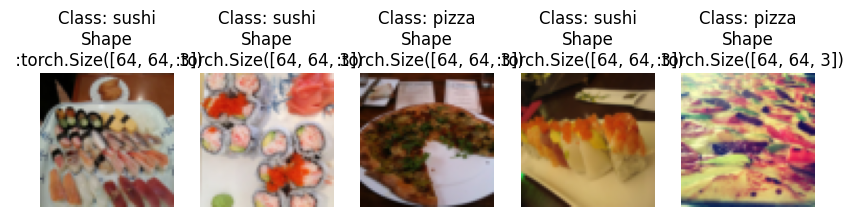

In [81]:
display_random_images(train_data,
                      n = 5,
                      classes=class_names,
                      seed = None
                      )

Turning Custom loaded data into "Data loader"

In [82]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32
train_dataloader = DataLoader(dataset=train_data,
                              batch_size = BATCH_SIZE ,
                              num_workers = os.cpu_count(),
                              shuffle = True

                              )
test_dataloader = DataLoader(dataset =test_data,
                             batch_size = BATCH_SIZE,
                             num_workers = 1,
                             shuffle = False
                             
    
)
len(train_dataloader), len(test_dataloader)

(8, 3)

In [83]:
#Get image and label
img, label = next(iter(train_dataloader))
img.shape, label.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

Other forms of transfroms
- Let us look at trivial augment

In [84]:
#Create a transform
train_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
    
])
test_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [85]:
image_path

PosixPath('data/pizza_Steak_Sushi')

In [86]:
image_path_list = list(image_path.glob("*/*/*.jpg"))

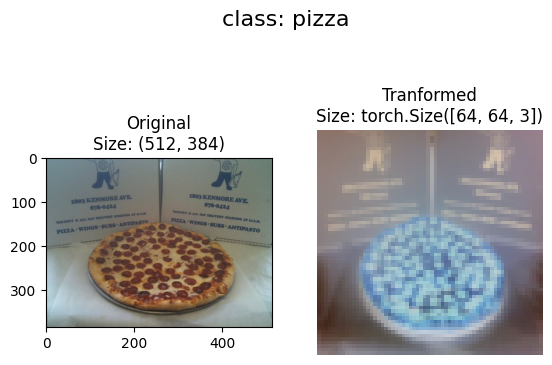

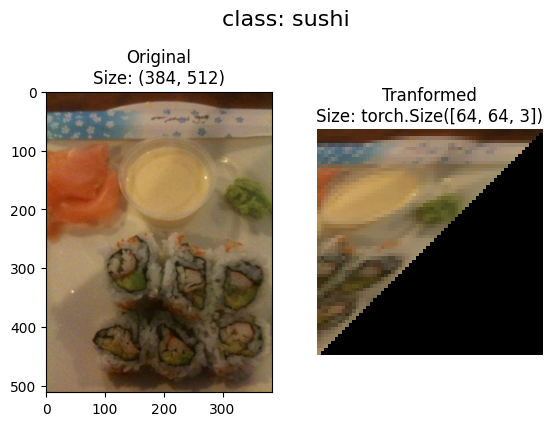

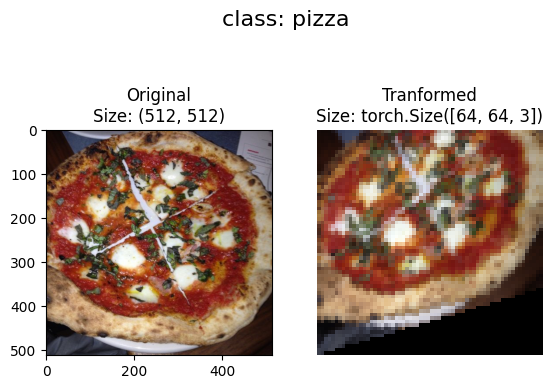

In [87]:

plot_transformed_imgs(image_paths=image_path_list,transform=train_transform,n=3)

Building computer vision baseline model

In [88]:
#Creating transfroms and loading data
simple_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [89]:
from torchvision import datasets
train_data_simple = datasets.ImageFolder(
    root=train_dir,
    transform = simple_transforms
)
test_data_simple = datasets.ImageFolder(
    root=test_dir,
    transform = simple_transforms
)
#Turn datasets into data loader
from torch.utils.data import DataLoader
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
train_dataloader_simple = DataLoader(
    dataset = train_data_simple,
    batch_size = BATCH_SIZE,
    shuffle=True,
    num_workers = NUM_WORKERS
)
test_dataloader_simple = DataLoader(
    dataset = test_data_simple,
    batch_size = BATCH_SIZE,
    shuffle=False,
    num_workers = NUM_WORKERS
)




Creating tiny VGG model

In [90]:
from torch.nn.modules.pooling import MaxPool2d
class TinyVGG(nn.Module):
  def __init__(self,
               input_shape:int,
               hidden_units:int,
               output_shape:int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels = hidden_units,
                  kernel_size=3,
                  stride= 1,
                  padding=0
                  ),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size= 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3,
                     stride=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels = hidden_units,
                  kernel_size=3,
                  stride= 1,
                  padding=0
                  ),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size= 3,
                  stride = 1,
                  padding = 0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3,
                     stride=2)
    )
    self.classifier_layer = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units * 12 * 12,
                  out_features=output_shape)
    )
  
  def forward(self,x):
    x = self.conv_block_1(x)
    x = self.conv_block_2(x)
    x = self.classifier_layer(x)
    return x


In [92]:
device

'cuda'

In [91]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)
model_0

RuntimeError: ignored

In [ ]:
#Passing dummy data to correct shape mismatch in forward me
image_batch,label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

In [ ]:
model_0(image_batch.to(device))

In [ ]:
!pip install torchinfo

In [ ]:
#Using torch info package to view model summary
import torchinfo
from torchinfo import summary
summary(model_0,input_size=[1,3,64,64])

Training tinyVGG model

In [ ]:
#Creating training and test loop
#Create train step
def train_step(model:torch.nn.Module,
               dataloader:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
               optimizer:torch.optim.Optimizer,
               device = device):
  model.train()

  train_loss, train_acc = 0, 0
  #loop through dataloader

  for batch, (X,y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    y_pred = model(X)

    loss = loss_fn(y_pred,y)

    train_loss += loss.item()

    #optimizer zero grad
    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    #Calculate accuracy
    y_pred_class = torch.argmax(torch.softmax(y_pred,dim=1),dim=1)
    train_acc += (y_pred_class == y).sum().item() / len(y_pred)
  #Adjust metrics to get average loss and accuracy
  train_loss = train_loss / len(dataloader)

  train_acc = train_acc / len(dataloader)

  return train_loss, train_acc


In [ ]:
#Create a test function
def test_step(model:torch.nn.Module,
              dataloader:torch.utils.data.DataLoader,
              loss_fn:torch.nn.Module,
              device = device
              ):
  #put model in eval mode
  model.eval()

  #set up test loss and test acc
  test_loss, test_acc = 0,0

  with torch.inference_mode():
    for batch, (X,y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)

      test_pred_logits = model(X)

      loss = loss_fn(test_pred_logits,y)
      test_loss += loss.item()

      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += (test_pred_labels == y).sum().item() / len(test_pred_labels)
    #Adjust for average loss and accuracy per batch

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc/ len(dataloader)

    return test_loss,test_acc

In [ ]:
#Create a function for train to combine train and test step
from tqdm.auto import tqdm
def train(
    model:torch.nn.Module,
    train_dataloader:torch.utils.data.DataLoader,
    test_dataloader:torch.utils.data.DataLoader,
    optimizer:torch.optim.Optimizer,
    loss_fn:torch.nn.Module = nn.CrossEntropyLoss(),
    epochs:int = 5,
    device = device
    ):
  results = {"train_loss":[],
             "train_acc":[],
             "test_loss":[],
            "test_acc":[]}
  for epoch in tqdm(range(epochs)):
    train_loss,train_acc = train_step(
        model,
        dataloader=train_dataloader,
        loss_fn=loss_fn,
        optimizer = optimizer,
        device = device
    )
    test_loss, test_acc = test_step(
        model = model,
        dataloader = test_dataloader,
        loss_fn = loss_fn,
        device = device
    )

    print(f"Epoch:{epoch} | Train loss: {train_loss:.4f} | Train_acc: {train_acc:.4f} Test loss: {test_loss:.4f} | Test_acc: {test_acc:.4f}")

    #Update result dictionary

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  
  return results
  

    
  

Training and evaluating baseline model

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

#set number of epochs
NUM_EPOCHS = 10

#create an instance of model
model_o = TinyVGG(input_shape = 3,
                  hidden_units = 10,
                  output_shape = len(train_data.classes)).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr = 0.001)

#Starte the timer 
from  timeit import default_timer as timer
start_time = timer()
model_0_results = train(
    model=model_0,
    train_dataloader = train_dataloader_simple,
    test_dataloader = test_dataloader_simple,
    optimizer = optimizer,
    loss_fn = loss_fn,
    epochs = NUM_EPOCHS
)

#End timer and print out how long it took
end_time = timer()
print(f"Total train time : {end_time - start_time:.3f} seconds")


In [ ]:
model_0_results

Plotting loss curves of model zero

In [ ]:
model_0_results.keys()

In [ ]:
def plot_loss_curves(results: Dict[str,List[float]]):
  #Get loss values of the results dictiomary
  loss = results["train_loss"]
  test_loss = results["test_loss"]


  accuracy = results["train_acc"]
  test_accury = results["test_acc"]
  epochs = range(len(results["train_loss"]))

  plt.figure(figsize=(15,7))
  plt.subplot(1,2,1)
  plt.plot(epochs,loss,label="train_loss")
  plt.plot(epochs,test_loss,label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(epochs,accuracy,label="train_accuracy")
  plt.plot(epochs,test_accury,label="test_Accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

plot_loss_curves(model_0_results)